In [3]:
# Universal imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import pickle as pk

#HyperUnmixing package import
sys.path.append("..")
from HyperUnmixing import *

#Paths to image data
IMG1_PATH = '../../data/DPPDTT-PS.npy'
IMG2_PATH = '../../data/image2.npy'
BASE_DPPDTT = '../../data/dppdtt_ground_truth.npy'
BASE_PS = '../../data/ps_ground_truth.npy'

# HyperUnmixing : CHEME 599 Course Project

## Team:
---
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Madeleine Breshears
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Caitlin Cornell
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Muammer Yaman
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4. Preetham Paul



# Motivations
---

Photo-induced force microscopy is a tool often used to visualize a variety of materials and how those materials' topographies, absorptions, and emissions behave under different excitation wavelengths.

Analysis of PiFM images relies on major assumptions:
- The ratio of the prepared solutions or samples is maintained post-preparation and during measurement
- Spectra of individual components can be parsed out of a spectrum of the mixed sample

A variety of techniques have been used to probe these assumptions, including Principal Component Analaysis and Principal Component Regression. These techniques allow us to better understand if intended ratios are maintained, how well mixed samples behave, and how sample preparation or sample interactions might affect spectra.

# Inspiration for HyperUnmixing

### The project is inspired from this paper : [Kong *et al.*](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b01003)

![title of paper](../data/paper_title.png)

### What does the paper show?

This study used Photo-induced Atomic Force Microscopy (Pi-AFM) images to construct hyperspectral images where each pixel has a depth of 1128 wavelengths. How are these images generated?

The spot where the AFM probe comes in contact is illuminated by varying wavelengths of IR radiation as shown in the image below. The AFM probe notes the signal of the sample at different vibrational modes triggered by varying the wavelength of illumination.

![Pi-AFM microscopy](../data/PiAFM.png)



From the data obtained from Pi-AFM,

![hyperspectral_image.png](../data/hyperspectral_image.png)

### In the paper, a hyperspectral image like this obtained from Pi-AFM is used to predict a conduction map obtained from conductive probe microscopy, using a linear regression on the principle components.

![worflow](../data/workflow.png)

### This gave an idea to the "HyperUnmixing" project in which we explored tools that can 'unmix' and analyze hyperspectral images like these.

## Principal Component Analysis (PCA):

A nice small tutorial for PCA is available [here](https://pdfs.semanticscholar.org/a99e/0f8f58af7a91e26c1eda54e0cca3e3e03df3.pdf?_ga=2.145751990.38709335.1591063750-1382180718.1591063750).

In PCA, from the data spread, we try to extract the significant directions along which the variance is maximum. These directions would be the linear combinations of the original directions or features and are called principle components.

![PCA_intro1.png](../data/PCA_intro1.png)

The number of principle components to take depends on the distribution of total variance among the principle components. In the example above, one PC is sufficient.

### Initial Steps in PCA:
1. The main assumption for PCA is that all data follows a gaussian distribution around a mean point. So, we shift the origin to this mean point.
2. Then we look for directions along which the variance would be minimum.


Load the image and normalize it. Change the IMG_PATH to the location where image is stored.

In [5]:
im = np.load(IMG1_PATH, allow_pickle= True)
im = normalization(im[:100,:100,:])
im.shape

(100, 100, 1128)

Each pixel in the image has a depth of 1128 layers, that is each pixel is a spectrum as shown below.

Text(0.5, 1.0, 'Depth of the pixel at (50,50)')

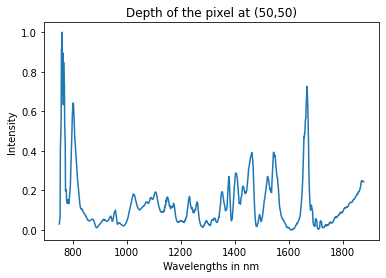

In [6]:
plt.plot(750 + np.arange(im.shape[2]), im[50,50,:])
plt.xlabel('Wavelengths in nm')
plt.ylabel('Intensity')
plt.title("Depth of the pixel at (50,50)")

`get_PC` function from the pca_util file in HyperUnmixing package can be used to do Principle Component Analysis on the image. The function considers each pixel independent, and takes the 1128 wavelengths in the depth of each pixel as features. PCA is done on these to get the their loading scores (or coefficients) in each PC.

In [7]:
#Get principle components
(loading_scores, scree_values) = get_PC(im)

#Loading the ground truths
dppdtt = np.load(BASE_DPPDTT)
dppdtt = dppdtt/np.max(dppdtt)

ps = np.load(BASE_PS)
ps = ps/np.max(ps)

#Features or depth of each pixel
feat_arr = np.arange(750, 750+im.shape[2], 1)

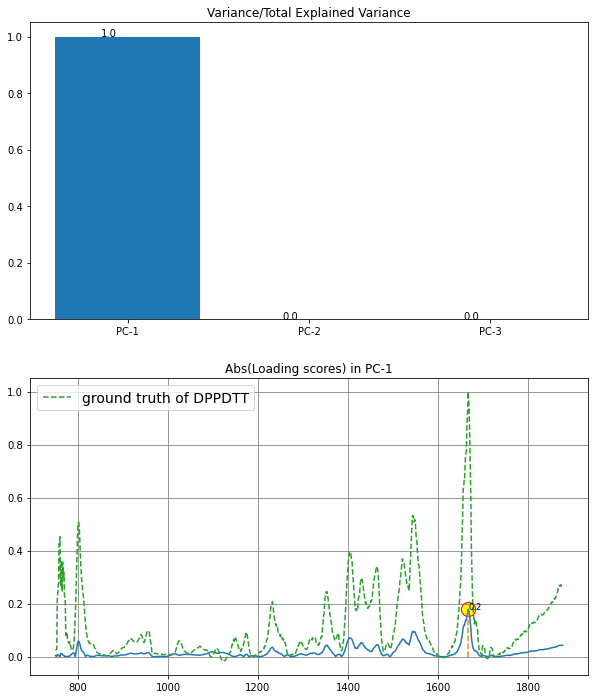

In [8]:
#PLOTTING PC-1
fig, ax = plt.subplots(nrows=2, figsize = (10,12))
ax = plot_PCs(ax, loading_scores, scree_values, top_n=3, PC_n=1, top_load_n=1)
ax[1].plot(feat_arr, dppdtt, label = 'ground truth of DPPDTT', linestyle='dashed')
ax[1].legend(fontsize=14)

Once the loading scores are obtained, just PC-1 and PC-2 alone can be used to represent the entire hyperspectral image.
If we compare these with the pure DPPDT and pure PSS plots,




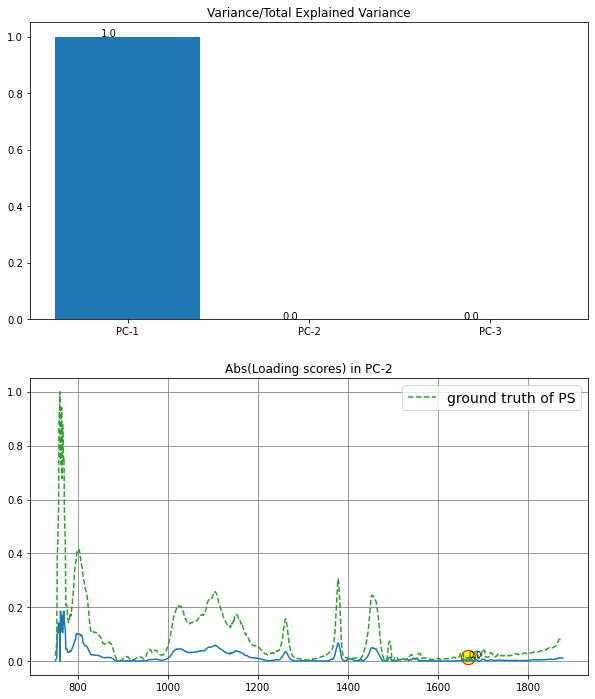

In [9]:
#PLOTTING PC-2
fig, ax = plt.subplots(nrows=2, figsize = (10,12))
ax = plot_PCs(ax, loading_scores, scree_values, top_n=3, PC_n=2, top_load_n=1)
ax[1].plot(feat_arr, ps, label = 'ground truth of PS', linestyle='dashed')
ax[1].legend(fontsize=14)

## How can we use PCA to get the fraction of polymer present?

## Dimentionality reduction of image depth from 1128 to 2


Using the linear combination of PC coefficients and the pixel spectra, we can decrease the dimensions to 2.

In [10]:
new_im = make_PC_images(im, loading_scores, PC_num=[1, 2])

Text(0.5, 1.0, 'PC-2 image corresponding to PS')

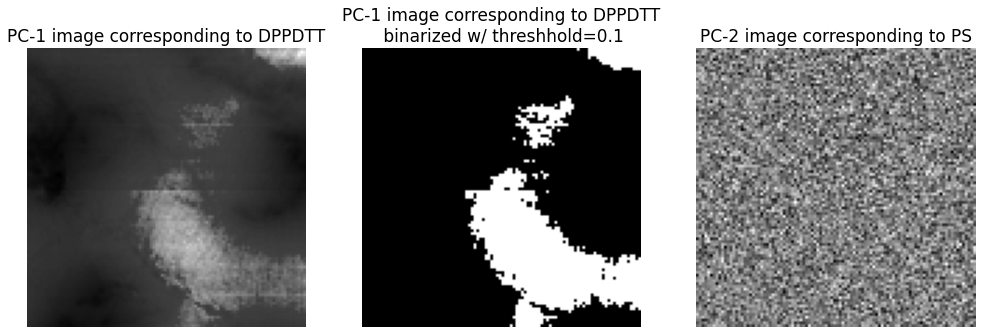

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(17,8))

ax[0].imshow(new_im[:,:,0], cmap='gray')
ax[0].axis('off')
ax[0].set_title("PC-1 image corresponding to DPPDTT", fontsize=17)

#Binarizing the DPPDT image
thresh = 0.1
binary_im = mask_im(new_im[:,:,0], thresh)
ax[1].imshow(binary_im, cmap='gray')
ax[1].axis('off')
ax[1].set_title("PC-1 image corresponding to DPPDTT\n binarized w/ threshhold={}".format(thresh), fontsize=17)

ax[2].imshow(new_im[:,:,1], cmap='gray')
ax[2].axis('off')
ax[2].set_title("PC-2 image corresponding to PS", fontsize=17)

## Major Drawback of PCA:

### As we see above, PC-2 fails to highlight PS rich regions. This is because, PCA assumes a normal distribution, i.e, assumes that data is centered about a single mean. So, here, it assumes that data is scattered about DPPDTT spectra because this component is dominating.

### So, we explored other factorizing or dimensionality-reducing methods to mitigate this. NMF was our next attempt.

---

# So, what is NMF?
---

Non-negative Matrix Factorization (NMF) is a technique that has a variety of applications. It's most common application is in image analysis.

NMF approximates matrix $X$ by decomposing it into component matrices $W$ and $H$.

<h1><center>$X = WH$</center></h1>

The $W$ matrix is often considered the *weight* matrix while the $H$ matrix contains the given number of *components*.



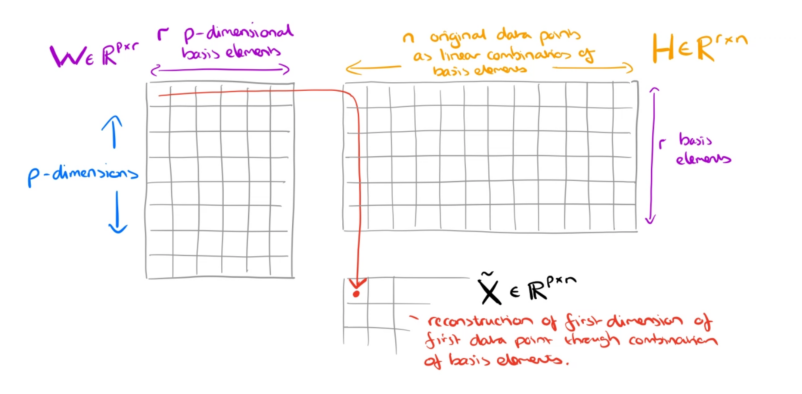

In [13]:
fig, ax = plt.subplots(figsize = (18,7))
figure = plt.imread('../../data/NMF.PNG')
ax.imshow(figure)
ax.axis('off')
plt.show()

[Source for image.](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/)

### Our goal: Given a hyperspectral image (stacks of many images taken at different excitation wavenumbers), what are the weight matrices and component spectra of a mixed polymer sample?

### How NMF helps:
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Non-negativitiy applied to all components (no such thing as a negative polymer!)
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Highly custommizable for >2 polymer blends

---

# Hyperspectral datasets
---

We'll be focusing on *hyperspectral* data sets. We often refer to these as data cubes. Essentially, for each excitation wavenumber of a given range, we take an image of our sample. You can imagine these images stacked on top of each other with the same x,y coordinates but different intensity values.

![hyperspectral_image.png](../data/hyperspectral_image.png)

In [14]:
image = np.load(IMG2_PATH)
im = sample(image, 32)

interactive_hyperimage(im)

interactive(children=(IntSlider(value=1313, description='a', max=1877, min=750), Output()), _dom_classes=('wid…

<function HyperUnmixing.visualization.interactive_hyperimage.<locals>.update(a)>

# Highlights of HyperUnmixing package

---

# Operational functions on hyperspectral PiFM data cubes

There are two goals for processing hyperspectral polymer-blend data cubes: 1) Decompose the image into the component ground-truth spectra of the polmyers, and 2) Construct and image which encodes information about the coefficients of each polymer blend at each pixel.

First, we will utilize Non-Negative Matrix Factorization (NMF) to decompose the data cube into its component spectra. As explained earlier, we will get both the component spectra (the H matrix) and a matrix of coefficients (the W matrix). We will use the W matrix to build a normalized image of the polymer coefficients and then construct a threshold mask to spatially demonstrate the mixing of the polymers in the blend.

## Image Processing tools
---

Perform NMF on the datacube. We will use a customized function adapted from sklearn.decomposition.NMF and we will obtain an H matrix (the components) and a W matrix (the coefficients).

In [21]:
W_mat, H_mat = run_nmf(im, comps=2)

Lets take a look at the function we just performed

In [22]:
print(run_nmf.__doc__)


    Performs NMF analysis on a give image.

    Processing wrapper for NMF on 3D data cubes for hyperspectral images with a given number of components.

    Parameters
    ----------
    im : numpy array
        3D data cube of hyperspectral image
    comps : integer
        Number of components that NMF will try to identify
    solver : string (optional)
        Either 'cd' or 'mu' for coordinate descent or multiplicative update; default 'cd'
    tol : float (optional)
        Tolerance factor; adjust to smaller if analysis requires more precision; default 1e-5
    max_iter : integer (optional)
        Number of iterations NMF algorithm will attempt to separate components; adjust as necessary for attempts and/or time constraints; default int(1e6)
    l1_ratio : float (optional)
        Algorithm step size factor; adjust to smaller or larger to change fitting/overfitting; default 0.2
    alpha : float (optional)
        Algorithm step size factor; default 1e-3
    verbose : Boolean (o

### How can we assign NMF component spectra to ground truths?

First, let's get initialize a **dictionary** of our ground truth spectra.

In [23]:
ps_truth = np.load(BASE_PS)
dppdtt_truth = np.load(BASE_DPPDTT)

ps = np.interp(ps_truth, (ps_truth.min(), ps_truth.max()), (0,1))
dppdtt = np.interp(dppdtt_truth, (dppdtt_truth.min(), dppdtt_truth.max()), (0,1))

truths = {'ps': ps, 'dppdtt': dppdtt}

Let's look at the logic inside `check_comps(comps, truths)`:

`matches = {}

    for i in range(comps.shape[0]):
        comps[i,:] = np.interp(comps[i,:], (comps[i,:].min(), comps[i,:].max()), (0,1))

    for key in truths:
        matches[key] = {'truth':truths[key],
                        'NMF':None,
                        'RMSE':None,
                        'Index':None}
    rmse_vals = {}

    for key in truths:
        rmse_vals[key] = {}
        for i in range(comps.shape[0]):
            rmse_vals[key][i] = mean_squared_error(truths[key], comps[i,:], squared = False)

    for i in range(comps.shape[0]):
        val = 1000000000
        min_key = None
        for key in truths: 
            if val > rmse_vals[key][i]:
                val = rmse_vals[key][i]
                min_key = key
            else:
                pass
        matches[min_key]['NMF'] = comps[i,:]
        matches[min_key]['RMSE'] = val
        matches[min_key]['Index'] = i

    return matches`

So, with each step, we are minimizing the RMSE between the NMF component and ground truth.

In [25]:
matches = check_comps(H_mat, truths)

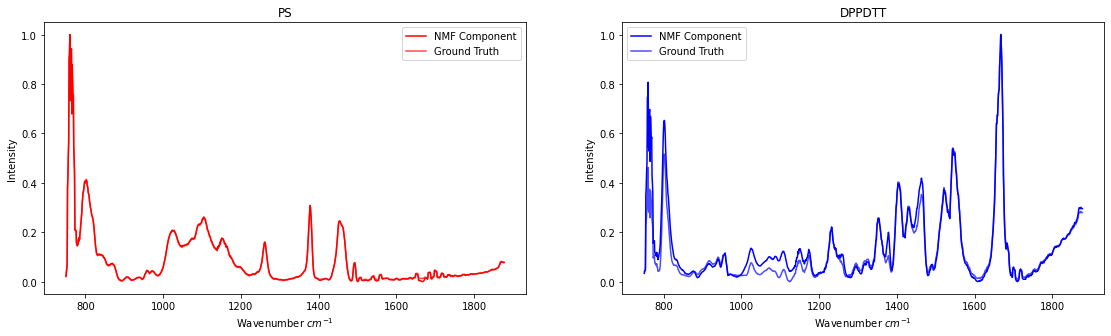

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (19,5))

x = np.arange(750,1878)

ax[0].plot(x, matches['ps']['NMF'], color = 'red', label = 'NMF Component')
ax[0].plot(x, matches['ps']['truth'], color = 'red', alpha = 0.7, label = 'Ground Truth')
ax[0].set_xlabel('Wavenumber $cm^{-1}$')
ax[0].set_ylabel('Intensity')
ax[0].set_title('PS')
ax[0].legend()

ax[1].plot(x, matches['dppdtt']['NMF'], color = 'blue', label = 'NMF Component')
ax[1].plot(x, matches['dppdtt']['truth'], color = 'blue', alpha = 0.7, label = 'Ground Truth')
ax[1].set_xlabel('Wavenumber $cm^{-1}$')
ax[1].set_ylabel('Intensity')
ax[1].set_title('DPPDTT')
ax[1].legend()

plt.show()

Our spectra match! Looks like NMF did a good job decomposing the original image and our `check_comps` function was able to correctly identify which is which!

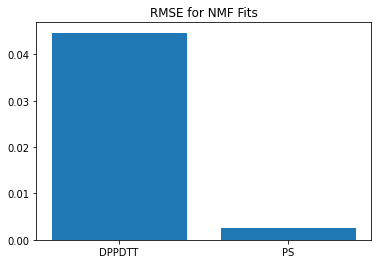

In [27]:
plt.bar([0.5, 1.5],[matches['dppdtt']['RMSE'], matches['ps']['RMSE']])
plt.xticks([0.5,1.5], ['DPPDTT', 'PS'])
plt.title('RMSE for NMF Fits')
plt.show()

In addition to the ground truths, NMF components, and RMSE values saved in the `matches` dictionary, we also have a key for the *index* of the matched component. We can use that same index to parse through the W matrix.

Now, lets visualize the coefficients from the W matrix. We know from the check_comps function which set of coefficients applies to which polmyer. In this case, DPPDTT is the 0th element and PS is the 1st element.

First we need to reshape the W matrix as it was returned in a flattened form.

In [29]:
coeffs = W_mat.reshape(32,32,2)

Text(0.5, 1.0, 'Coefficients of PS')

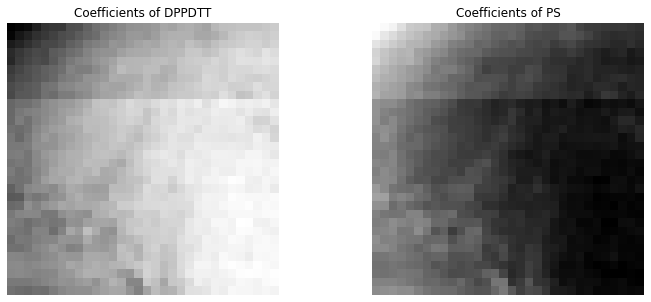

In [30]:
figs, axes = plt.subplots(ncols=2, figsize=(12, 5))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(coeffs[:,:,0], cmap='gray')
axes[0].set_title('Coefficients of DPPDTT')

axes[1].imshow(coeffs[:,:,1], cmap='gray')
axes[1].set_title('Coefficients of PS')

As we would expect, the coefficient images are basically the opposite of each other. However, we can see that they don't exactly add up to 1.

In [31]:
print('DPPDTT slice = {}'.format(coeffs[13,13,0]))
print('PS slice = {}'.format(coeffs[13,13,1]))
print('And the sum is : {}'.format(coeffs[13,13,0] + coeffs[13,13,1]))

DPPDTT slice = 1.0303969873345764
PS slice = 0.10893813024374072
And the sum is : 1.139335117578317


We need to normalize the coefficient image relative to one polmyer - we will use DPPDTT (integer value 0).

We will also revert to using the W_mat instead of the reshaped coeffs because the normalization function reshapes the
W matrix for us!

In [32]:
norm_im = norm_W(W_mat, 0)

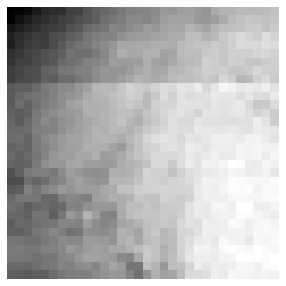

In [33]:
fig, ax = plt.subplots(figsize=(5,5))

ax.axis('off')
ax.imshow(norm_im, cmap='gray')

With this normalized image, we can create a thresholded mask of the image to visualize on an original slice of the image the parts that are over a certain percentage DPPDTT

We will use a custom function that takes as input the normalized image and a value to threshold.

In [36]:
mask = mask_im(norm_im, 0.8)

Lets visualize the mask along with the masked overlay on an original image slice at wavenumber 1550

Text(0.5, 1.0, 'Masked Image')

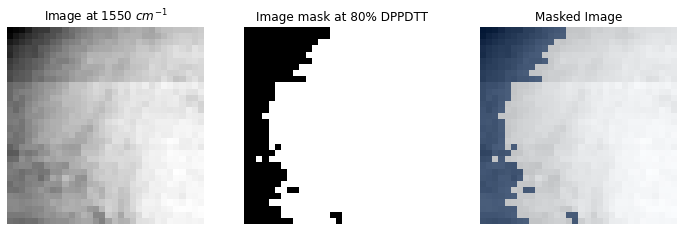

In [37]:
figs, axes = plt.subplots(ncols=3, figsize=(12, 5))

for ax in axes:
    ax.axis('off')

axes[0].imshow(im[:,:,1550-750], cmap='gray')
axes[0].set_title(r'Image at 1550 $cm^{-1}$')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Image mask at 80% DPPDTT')

axes[2].imshow(im[:,:,1550-750], cmap='gray')
axes[2].imshow(mask, cmap='Blues_r', alpha=0.5)
axes[2].set_title('Masked Image')


## User interactive visualization methods
---

In this section, we will visualize individual normalized slices from a datacube and use threshold masks to compute the area fraction of one polymer in the blend for an image slice.

Let's visualize the datacube with interactive tool. You can see the image at desired wavenumber

In [38]:
interactive_hyperimage(im, w=(750,1877,1))

interactive(children=(IntSlider(value=1313, description='a', max=1877, min=750), Output()), _dom_classes=('wid…

<function HyperUnmixing.visualization.interactive_hyperimage.<locals>.update(a)>

Let's visualize the datacube at several different wavenumbers

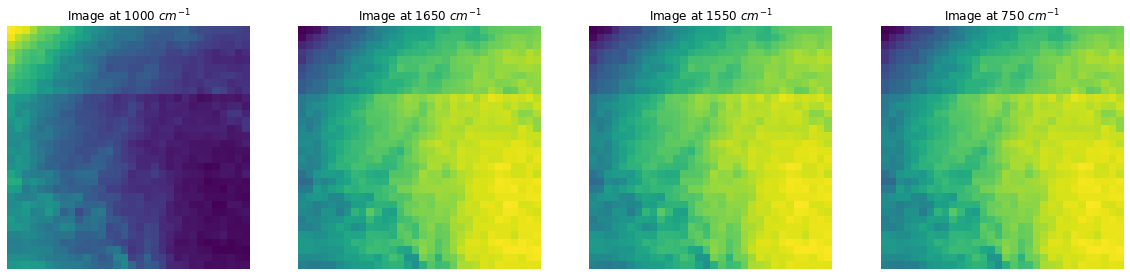

In [39]:
figs, axes = plt.subplots(ncols=4, figsize=(20,5))
im1000 = Wav_2_Im(im, 1000)
im1650 = Wav_2_Im(im, 1650)
im1550 = Wav_2_Im(im, 1550)
im750 = Wav_2_Im(im, 750)

for ax in axes:
    ax.axis('off')

axes[0].imshow(im1000)
axes[0].set_title(r'Image at 1000 $cm^{-1}$')

axes[1].imshow(im1650)
axes[1].set_title(r'Image at 1650 $cm^{-1}$')

axes[2].imshow(im1550)
axes[2].set_title(r'Image at 1550 $cm^{-1}$')

axes[3].imshow(im750)
axes[3].set_title(r'Image at 750 $cm^{-1}$')
plt.show()

We can also compute the area fraction of the image that is a certain percentage (or more) of DPPDTT and a variety of thresholds

In [40]:
props, ims, fracs = AreaFraction(im1550, norm_im, 64)

Lets see the masks

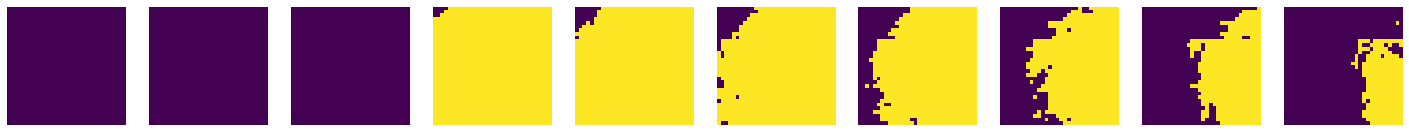

In [41]:
figs, axes = plt.subplots(ncols=10, figsize=(25,3))

for i in range(ims.shape[2]):
        axes[i].axis('off')
        axes[i].imshow(ims[:,:,i])


Now, lets plot the area fraction as a function of the threshold value

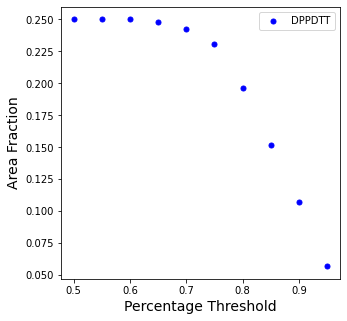

In [42]:
sum_fracs = []
for i in range(len(fracs)):
    sum_fracs.append(np.sum(fracs[i]))

figs, axes = plt.subplots( figsize=(5,5))
percents = np.round(np.arange(0.5, 1.0, 0.05),2)

axes.plot(percents, np.array(sum_fracs), linestyle="None", marker="o", markersize=5, color='b', label="DPPDTT")
axes.set_ylabel('Area Fraction', fontsize=14)
axes.set_xlabel('Percentage Threshold', fontsize=14)
axes.legend()

# Building on this Project in the *Future*!

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - modifying the `check_comps` function to take .json files instead of dictionaries of ground truths
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - "Classifying" the package, or turning hyperspectral images into Classes with the analyses functions given above acting as methods
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - making a pip installable package
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - internally normalizing for intensity markers